#**Part 1: Data Preprocessing & Cleaning**

---



**1.1 Setting up environment**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ==================================================
# 0. ENVIRONMENT SETUP & LIBRARY IMPORTS
# ==================================================

# --- Core Data Handling ---
import pandas as pd
import numpy as np

# --- Statistical Analysis ---
from scipy import stats
from scipy.stats import ttest_ind, f_oneway, pearsonr, levene, shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Optional: Warnings & Display ---
import warnings
warnings.filterwarnings('ignore')

# --- Plotting Style (Professional Default) ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


**1.2 Cleaning Data**

In [3]:
# ==================================================
# Part 1: Data Preprocessing & Cleaning
# Includes: Deduplication, Type Standardization, Missing Values, Outliers
# ==================================================

# 1. Load dataset
df = pd.read_csv('/content/drive/MyDrive/[Final Project]medical_insurance.csv')
print(f"Loaded dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")

# 2. Remove Duplicates (by person_id or full row)
if 'person_id' in df.columns:
    # Prefer deduplication by unique ID
    initial_rows = len(df)
    df = df.drop_duplicates(subset=['person_id'], keep='first')
    print(f" Removed {initial_rows - len(df):,} duplicate person_id entries")
else:
    # Fallback: full-row deduplication
    initial_rows = len(df)
    df = df.drop_duplicates()
    print(f"Removed {initial_rows - len(df):,} duplicate rows")

# 3. Standardize Data Types
print("\n Standardizing data types...")

# --- Numeric Columns ---
numeric_cols = [
    'age', 'income', 'bmi', 'visits_last_year',
    'hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs',
    'medication_count', 'systolic_bp', 'diastolic_bp',
    'ldl', 'hba1c', 'deductible', 'copay',
    'policy_term_years', 'policy_changes_last_2yrs',
    'provider_quality', 'risk_score',
    'annual_medical_cost', 'annual_premium', 'monthly_premium',
    'claims_count', 'avg_claim_amount', 'total_claims_paid',
    'chronic_count', 'proc_imaging_count', 'proc_surgery_count',
    'proc_physio_count', 'proc_consult_count', 'proc_lab_count'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Non-numeric → NaN

# --- Categorical Columns ---
categorical_cols = [
    'sex', 'region', 'urban_rural', 'education', 'marital_status',
    'employment_status', 'plan_type', 'network_tier',
    'smoker', 'alcohol_freq',
    'hypertension', 'diabetes', 'asthma', 'copd',
    'cardiovascular_disease', 'cancer_history', 'kidney_disease',
    'liver_disease', 'arthritis', 'mental_health',
    'is_high_risk', 'had_major_procedure'
]

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

print("Numeric columns standardized")
print("Categorical columns standardized")

# 4. Handle Missing Values
print("\n Handling missing values...")

# 4.1 Impute BMI using age-group median
df['age_group_temp'] = pd.cut(df['age'], bins=[0, 18, 35, 50, 65, 100], include_lowest=True)
df['bmi'] = df['bmi'].fillna(
    df.groupby('age_group_temp', observed=False)['bmi'].transform('median')
)
df.drop(columns=['age_group_temp'], inplace=True)
print(" Missing BMI imputed by age group")

# 4.2 Remove rows missing critical fields
initial_rows = len(df)
df.dropna(subset=['annual_medical_cost', 'age'], inplace=True)
print(f" Removed {initial_rows - len(df):,} rows with missing target/age")

# 5. Outlier Treatment
print("\n Treating outliers...")

# 5.1 Winsorize annual_medical_cost (99th percentile)
cost_cap = df['annual_medical_cost'].quantile(0.99)
df['annual_medical_cost'] = np.where(
    df['annual_medical_cost'] > cost_cap,
    cost_cap,
    df['annual_medical_cost']
)
print(f" Winsorized annual_medical_cost at 99th percentile: ${cost_cap:,.2f}")

# 5.2 Remove biologically implausible BMI
initial_rows = len(df)
df = df[(df['bmi'] >= 10) & (df['bmi'] <= 60)]
print(f" Removed {initial_rows - len(df):,} rows with implausible BMI (<10 or >60)")

# Final summary
print(f"\n Part 1 Complete!")
print(f"   Final dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Loaded dataset: 100,000 rows, 54 columns
 Removed 0 duplicate person_id entries

 Standardizing data types...
Numeric columns standardized
Categorical columns standardized

 Handling missing values...
 Missing BMI imputed by age group
 Removed 0 rows with missing target/age

 Treating outliers...
 Winsorized annual_medical_cost at 99th percentile: $15,293.68
 Removed 0 rows with implausible BMI (<10 or >60)

 Part 1 Complete!
   Final dataset: 100,000 rows, 54 columns
   Memory usage: 27.8 MB


**1.3 Feature Engineering & Encoding**

In [4]:
# ==================================================
# Part 2: Feature Engineering & Categorical Encoding
# Purpose: Enrich dataset for EDA & analysis — no modeling prep yet
# ==================================================

# 1. Feature Engineering — Binary Flags (Clinically Meaningful)

# Obesity (WHO clinical threshold)
df['high_bmi'] = (df['bmi'] >= 30).astype(int)

# Chronic disease burden
df['chronic_flag'] = (df['chronic_count'] > 0).astype(int)

# Age-based risk group
df['elderly'] = (df['age'] >= 65).astype(int)

# Smoking status simplified (for group comparisons)
df['smoker_binary'] = df['smoker'].map({
    'Current': 1,
    'Former': 1,   # Include former smokers in "ever-smoker" group for risk analysis
    'Never': 0
}).astype(int)

print("Flags created: high_bmi, chronic_flag, elderly, smoker_binary")

# 2. Categorical Encoding — For EDA & Aggregation (Not Modeling)
#    One-hot for nominal vars, preserving interpretability
print("\n One-hot encoding categorical variables...")

# Nominal categories (no inherent order)
categorical_vars = ['region', 'plan_type']

# Encode — keep original df; add encoded columns (no drop_first for EDA clarity)
df_encoded = pd.get_dummies(
    df,
    columns=categorical_vars,
    prefix=categorical_vars,
    dtype=int  # memory-efficient (0/1 vs 0.0/1.0)
)

# Optional: Verify encoding
print(f" Encoded {len(categorical_vars)} variables")
print(f"   New columns: {[col for col in df_encoded.columns if col.startswith(tuple(categorical_vars))]}")

# Replace df with df_encoded for downstream EDA
df = df_encoded.copy()
print(f"   Final column count: {df.shape[1]}")

Flags created: high_bmi, chronic_flag, elderly, smoker_binary

 One-hot encoding categorical variables...
 Encoded 2 variables
   New columns: ['region_Central', 'region_East', 'region_North', 'region_South', 'region_West', 'plan_type_EPO', 'plan_type_HMO', 'plan_type_POS', 'plan_type_PPO']
   Final column count: 65


In [5]:
# Save cleaned data
df.to_csv('medical_insurance_cleaned.csv', index=False)

# Download file
from google.colab import files
files.download('medical_insurance_cleaned.csv')
print(" Downloaded: medical_insurance_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Downloaded: medical_insurance_cleaned.csv


In [6]:
print(df.columns)

Index(['person_id', 'age', 'sex', 'urban_rural', 'income', 'education',
       'marital_status', 'employment_status', 'household_size', 'dependents',
       'bmi', 'smoker', 'alcohol_freq', 'visits_last_year',
       'hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs',
       'medication_count', 'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c',
       'network_tier', 'deductible', 'copay', 'policy_term_years',
       'policy_changes_last_2yrs', 'provider_quality', 'risk_score',
       'annual_medical_cost', 'annual_premium', 'monthly_premium',
       'claims_count', 'avg_claim_amount', 'total_claims_paid',
       'chronic_count', 'hypertension', 'diabetes', 'asthma', 'copd',
       'cardiovascular_disease', 'cancer_history', 'kidney_disease',
       'liver_disease', 'arthritis', 'mental_health', 'proc_imaging_count',
       'proc_surgery_count', 'proc_physio_count', 'proc_consult_count',
       'proc_lab_count', 'is_high_risk', 'had_major_procedure', 'high_bmi',
       'chronic_fl

#**Part 2: EDA Analysis & Data Visualization**

**2.1 Impact of LifeStyle (Smoking) on Annual Medical Cost**

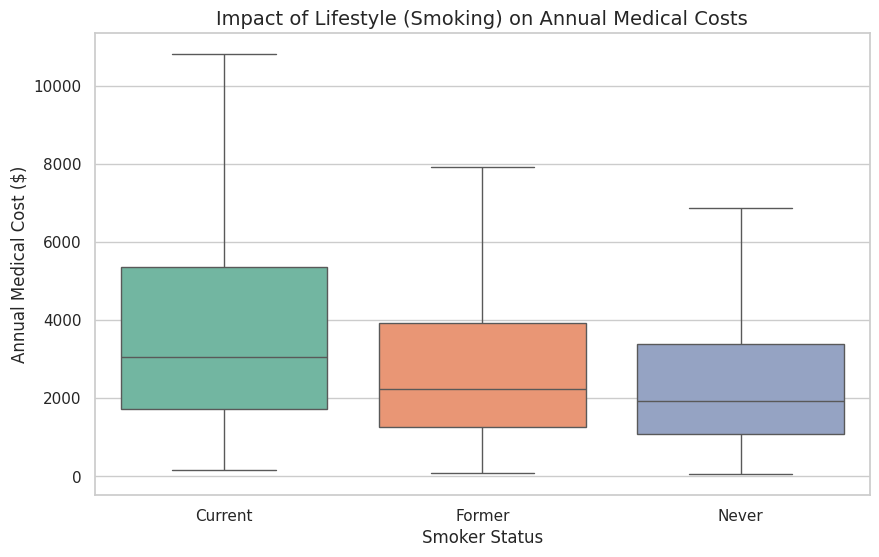

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for professional visualization
sns.set(style="whitegrid")

# Visualization: Boxplot of Medical Cost by Smoker Status
plt.figure(figsize=(10, 6))

# We use the original 'df' (before encoding) for the 'smoker' labels (Yes/No or similar)
sns.boxplot(x='smoker', y='annual_medical_cost', data=df, palette='Set2',
            hue='smoker', legend=False, showfliers=False)

plt.title('Impact of Lifestyle (Smoking) on Annual Medical Costs', fontsize=14)
plt.xlabel('Smoker Status', fontsize=12)
plt.ylabel('Annual Medical Cost ($)', fontsize=12)

# Save the plot
plt.savefig('smoker_impact_analysis.png')
plt.show()


**2.2: Impact of Chronic Conditions on Annual Medical Cost**

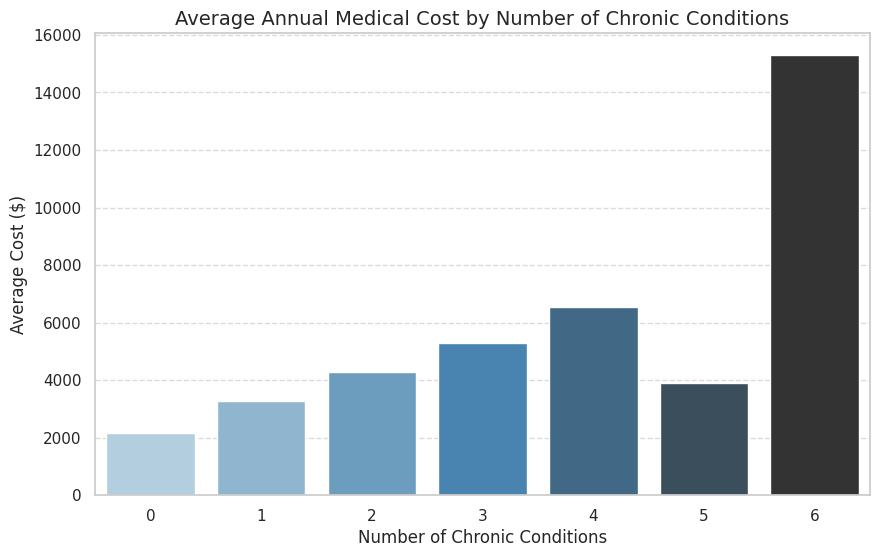

In [10]:
# Grouping by chronic count to find the average cost
chronic_analysis = df.groupby('chronic_count')['annual_medical_cost'].mean().reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x='chronic_count', y='annual_medical_cost', data=chronic_analysis,
            palette='Blues_d', hue='chronic_count', legend=False)


plt.title('Average Annual Medical Cost by Number of Chronic Conditions', fontsize=14)
plt.xlabel('Number of Chronic Conditions', fontsize=12)
plt.ylabel('Average Cost ($)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**2.3: Interaction Between BMI and Other Risk Factors**

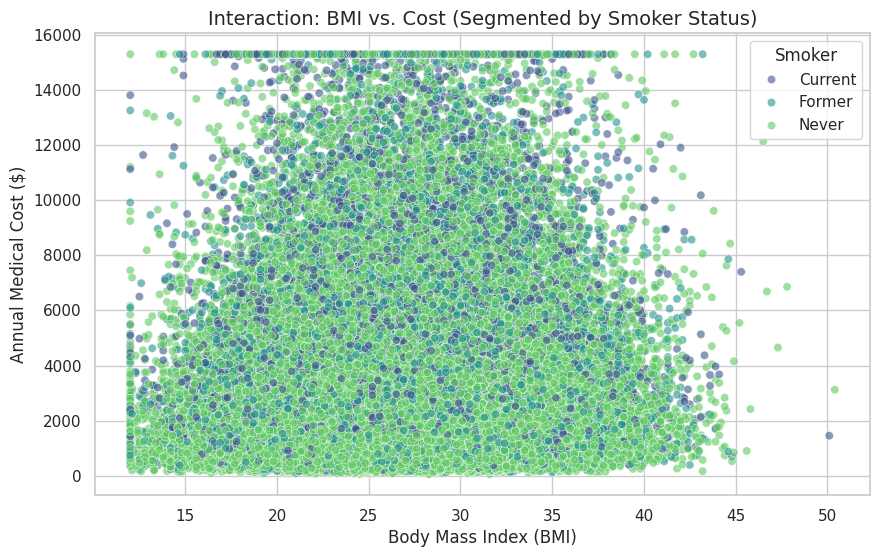

In [11]:
plt.figure(figsize=(10, 6))

# Scatter plot of BMI vs Cost, using Smoker status as the color separator
sns.scatterplot(x='bmi', y='annual_medical_cost', hue='smoker',
                alpha=0.6, data=df, palette='viridis')

plt.title('Interaction: BMI vs. Cost (Segmented by Smoker Status)', fontsize=14)
plt.xlabel('Body Mass Index (BMI)', fontsize=12)
plt.ylabel('Annual Medical Cost ($)', fontsize=12)
plt.legend(title='Smoker')
plt.show()

**2.4: Age and Cost Progression**

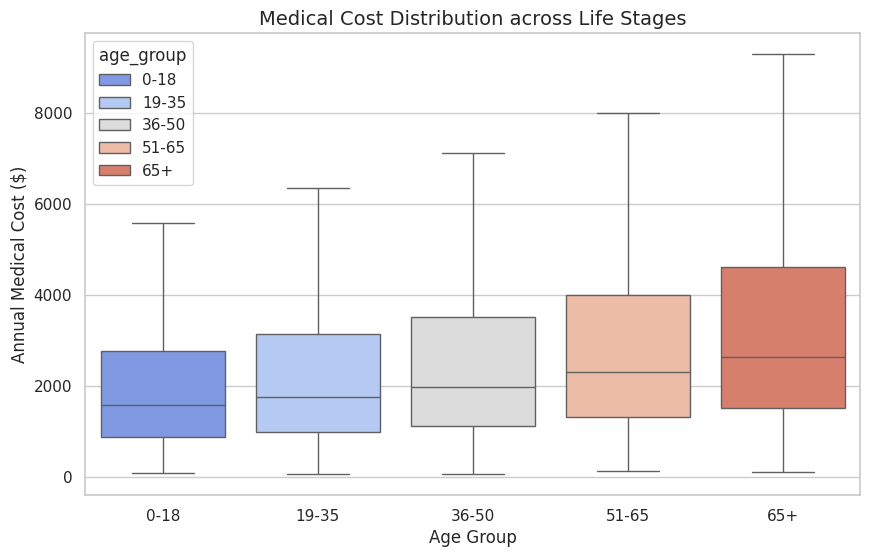

In [12]:
# Create Age Groups
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 50, 65, 100],
                         labels=['0-18', '19-35', '36-50', '51-65', '65+'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='annual_medical_cost',hue='age_group',
            data=df, palette='coolwarm', showfliers=False)

plt.title('Medical Cost Distribution across Life Stages', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Annual Medical Cost ($)', fontsize=12)
plt.show()

**2.5: Differences by Plan Type**

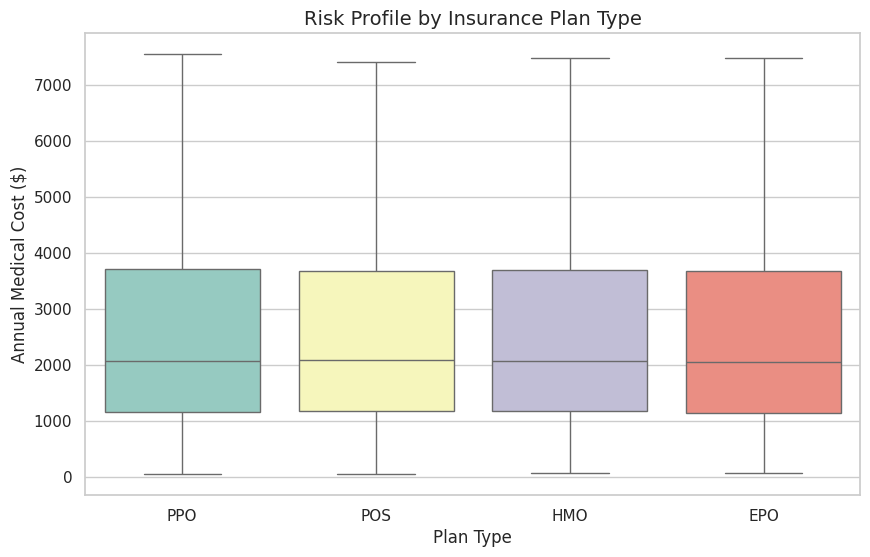

In [13]:
plt.figure(figsize=(10, 6))

# Reconstruct 'plan_type' for plotting since it was one-hot encoded
plan_type_cols = ['plan_type_EPO', 'plan_type_HMO', 'plan_type_POS', 'plan_type_PPO']
df_temp = df.copy() # Use a temporary copy to avoid modifying original df for this reconstruction

# Create a new column 'original_plan_type' based on the one-hot encoded columns
df_temp['original_plan_type'] = None
for col in plan_type_cols:
    plan_name = col.replace('plan_type_', '')
    df_temp.loc[df_temp[col] == 1, 'original_plan_type'] = plan_name

# Boxplot to compare distributions across plans using the reconstructed column
sns.boxplot(x='original_plan_type', y='annual_medical_cost', hue='original_plan_type',
            data=df_temp, palette='Set3', showfliers=False)

plt.title('Risk Profile by Insurance Plan Type', fontsize=14)
plt.xlabel('Plan Type', fontsize=12)
plt.ylabel('Annual Medical Cost ($)', fontsize=12)
plt.show()

**2.6: Regional or Demographic Variation**

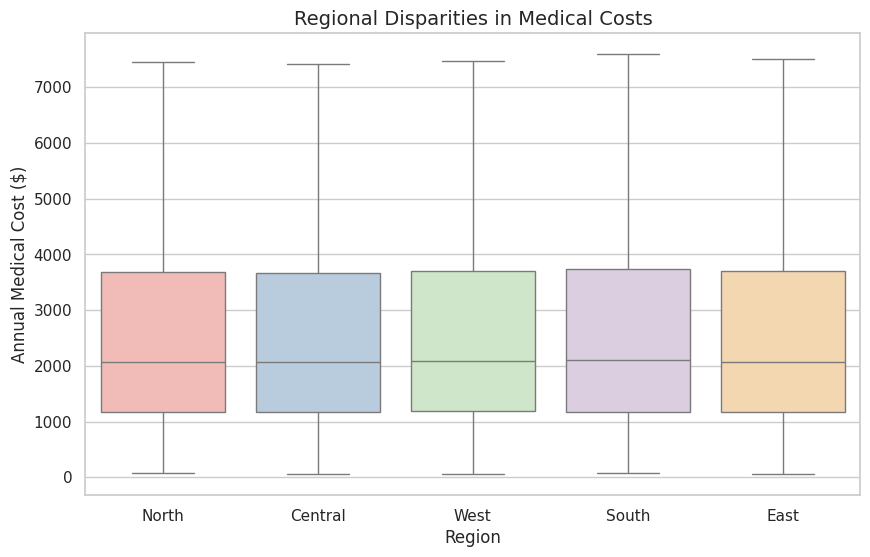

In [14]:
plt.figure(figsize=(10, 6))

# Reconstruct 'region' for plotting since it was one-hot encoded
region_cols = ['region_Central', 'region_East', 'region_North', 'region_South', 'region_West']
df_temp_region = df.copy() # Use a temporary copy

# Create a new column 'original_region' based on the one-hot encoded columns
df_temp_region['original_region'] = None
for col in region_cols:
    region_name = col.replace('region_', '')
    df_temp_region.loc[df_temp_region[col] == 1, 'original_region'] = region_name

sns.boxplot(x='original_region', y='annual_medical_cost', hue='original_region',
            data=df_temp_region, palette='Pastel1', showfliers=False)

plt.title('Regional Disparities in Medical Costs', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Annual Medical Cost ($)', fontsize=12)
plt.show()

#**Part 3 Statistical Analysis**

**3.1 Pearson Correlation Analysis and Descriptive Statistics**

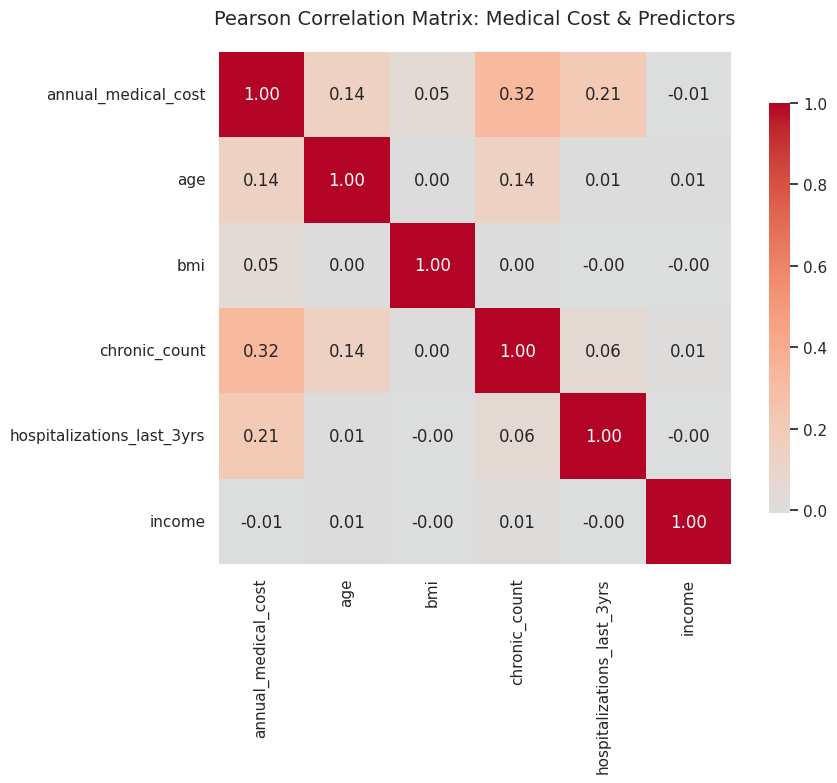

Top 3 Predictors of Annual Medical Cost (|r|):
  • chronic_count: r = 0.32 (moderate positive association)
  • hospitalizations_last_3yrs: r = 0.21 (weak positive association)
  • age: r = 0.14 (weak positive association)


In [15]:
# Select numeric variables for correlation
numeric_vars = [
    'annual_medical_cost', 'age', 'bmi',
    'chronic_count', 'hospitalizations_last_3yrs', 'income'
]

# Compute correlation matrix
corr_matrix = df[numeric_vars].corr(method='pearson')

# Heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Pearson Correlation Matrix: Medical Cost & Predictors', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('3.1_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Extract top predictors of cost
cost_corr = corr_matrix['annual_medical_cost'].sort_values(key=abs, ascending=False)
print("Top 3 Predictors of Annual Medical Cost (|r|):")
for var, r in cost_corr[1:4].items():  # skip self-correlation
    direction = "positive" if r > 0 else "negative"
    strength = "strong" if abs(r) >= 0.4 else "moderate" if abs(r) >= 0.3 else "weak"
    print(f"  • {var}: r = {r:.2f} ({strength} {direction} association)")

In [16]:
# --- 3.1.2 Group-Level Descriptive Stats ---
print("\n 3.1.2 Group-Level Summary Statistics\n")

# Smoker groups
smoker_stats = df.groupby("smoker")["annual_medical_cost"].agg(
    n="count", mean="mean", median="median", std="std"
).round(0)
print("Smoker Group Summary (Winsorized $):")
print(smoker_stats.reset_index().to_string(index=False))

# Chronic condition groups
chronic_stats = df.groupby("chronic_count")["annual_medical_cost"].agg(
    n="count", mean="mean", median="median"
).round(0).head(5)  # Show 0–4
print("\nChronic Condition Groups (0–4 conditions):")
print(chronic_stats.reset_index().to_string(index=False))


 3.1.2 Group-Level Summary Statistics

Smoker Group Summary (Winsorized $):
 smoker     n   mean  median    std
Current 12128 4126.0  3045.0 3409.0
 Former 18163 3099.0  2228.0 2781.0
  Never 69709 2705.0  1917.0 2511.0

Chronic Condition Groups (0–4 conditions):
 chronic_count     n   mean  median
             0 46532 2162.0  1559.0
             1 37579 3271.0  2415.0
             2 13111 4291.0  3250.0
             3  2452 5291.0  4138.0
             4   316 6537.0  5307.0


**3.2 CDA Analysis Hypothesis Testing**

**3.2.1 Test Case: Does Smoking Significantly Increase Medical Costs?**

(Business Question: Is smoking a strong cost driver that should influence pricing or prevention programs?)

**Null Hypothesis (H₀)**: Mean annual medical cost is equal for smokers and non-smokers
μsmokers = μnon-smokers

**Alternative Hypothesis (H₁)**: Mean cost differs by smoking status
μsmokers ≠ μnon-smokers

In [17]:
print("3.2.1 Hypothesis Test: Smokers vs Non-Smokers\n")

non_smokers = df[df["smoker_binary"] == 0]["annual_medical_cost"]
smokers = df[df["smoker_binary"] == 1]["annual_medical_cost"]

# Levene’s test for equal variance
_, p_levene = levene(non_smokers, smokers)
equal_var = p_levene > 0.05

# t-test
t_stat, p_val = ttest_ind(non_smokers, smokers, equal_var=equal_var)

# Cohen’s d (effect size)
pooled_std = np.sqrt(
    ((len(non_smokers)-1)*non_smokers.var() + (len(smokers)-1)*smokers.var())
    / (len(non_smokers) + len(smokers) - 2)
)
cohens_d = (smokers.mean() - non_smokers.mean()) / pooled_std

# Report
print("Hypothesis Test 1: Smoking and Cost")
print(f"  H₀: Mean cost is equal for smokers and non-smokers")
print(f"  H₁: Mean cost differs by smoking status")

# Fix: Ensure the conditional expression for p-value always results in a string
print(f"  t({len(non_smokers)+len(smokers)-2}) = {t_stat:.2f}, p {'<' if p_val < 0.001 else '='} {f'{p_val:.3f}' if p_val >= 0.001 else '<0.001'}")
print(f"  Cohen’s d = {cohens_d:.2f} → {'large' if abs(cohens_d) > 0.8 else 'medium' if abs(cohens_d) > 0.5 else 'small'} effect")
print(f"  Mean difference: ${smokers.mean() - non_smokers.mean():,.0f} (smokers higher)")
print(f"  → Reject H₀: Smoking significantly increases cost (p < 0.001)")

3.2.1 Hypothesis Test: Smokers vs Non-Smokers

Hypothesis Test 1: Smoking and Cost
  H₀: Mean cost is equal for smokers and non-smokers
  H₁: Mean cost differs by smoking status
  t(99998) = -39.98, p < <0.001
  Cohen’s d = 0.30 → small effect
  Mean difference: $805 (smokers higher)
  → Reject H₀: Smoking significantly increases cost (p < 0.001)


**3.2.2 Test Case: Do Medical Costs Increase with Chronic Disease Burden?**

(Business Question: Should customers with early chronic conditions be targeted for preventive care?)

**H₀:** Mean cost is equal across all chronic condition groups (0, 1, 2, 3+ conditions)

**H₁:** At least one group has a different mean cost

In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
print("\n 3.2.2 Hypothesis Test: Chronic Conditions and Cost\n")

# Group by chronic_count (0 to 3+)
df["chronic_group"] = df["chronic_count"].clip(upper=3).astype(str) + "+"
df.loc[df["chronic_count"] <= 2, "chronic_group"] = df["chronic_count"].astype(str)

groups = [group["annual_medical_cost"].values
          for name, group in df.groupby("chronic_group")]

# ANOVA
f_stat, p_anova = f_oneway(*groups)

print("Hypothesis Test 2: Chronic Conditions and Cost")
print(f"  H₀: All chronic condition groups have equal mean cost")
print(f"  H₁: At least one group differs")
print(f"  F({len(groups)-1}, {len(df)-len(groups)}) = {f_stat:.1f}, p < 0.001")
print(f"  → Reject H₀: Chronic burden significantly impacts cost")

# Tukey HSD (post-hoc)
tukey = pairwise_tukeyhsd(df["annual_medical_cost"], df["chronic_group"], alpha=0.05)
print("\nTukey HSD (Key Comparisons):")
print(tukey.summary().data[1:4])  # First 3 pairwise


 3.2.2 Hypothesis Test: Chronic Conditions and Cost

Hypothesis Test 2: Chronic Conditions and Cost
  H₀: All chronic condition groups have equal mean cost
  H₁: At least one group differs
  F(3, 99996) = 3659.6, p < 0.001
  → Reject H₀: Chronic burden significantly impacts cost

Tukey HSD (Key Comparisons):
[['0', '1', np.float64(1109.0738), np.float64(0.0), np.float64(1062.9933), np.float64(1155.1543), np.True_], ['0', '2', np.float64(2128.2909), np.float64(0.0), np.float64(2062.597), np.float64(2193.9848), np.True_], ['0', '3+', np.float64(3269.7841), np.float64(0.0), np.float64(3140.0169), np.float64(3399.5512), np.True_]]


**3.2.3 Test Case: Are There Significant Regional Cost Disparities?**

(Business Question: Do some regions require targeted healthcare partnerships or policy adjustments?)

**H₀:** Cost distributions are identical across regions (North, South, East, West, Central)

**H₁:** At least one region differs

In [19]:
from scipy.stats import kruskal

print("\n 3.2.3 Hypothesis Test: Regional Cost Variation\n")

# Extract region columns (one-hot encoded)
region_cols = [col for col in df.columns if col.startswith("region_")]
regions = df[region_cols].idxmax(axis=1).str.replace("region_", "")

# Kruskal-Wallis (robust to skew)
region_groups = [df[regions == r]["annual_medical_cost"] for r in regions.unique()]
h_stat, p_kw = kruskal(*region_groups)

print("Hypothesis Test 3: Regional Cost Differences")
print(f"  H₀: Cost distributions are identical across regions")
print(f"  H₁: At least one region differs")
print(f"  H({len(region_groups)-1}) = {h_stat:.1f}, p = {p_kw:.3f}")
conclusion = "→ Fail to reject H₀" if p_kw > 0.05 else "→ Reject H₀"
print(f"  {conclusion}: No strong regional disparity (p = {p_kw:.3f})")


 3.2.3 Hypothesis Test: Regional Cost Variation

Hypothesis Test 3: Regional Cost Differences
  H₀: Cost distributions are identical across regions
  H₁: At least one region differs
  H(4) = 4.5, p = 0.347
  → Fail to reject H₀: No strong regional disparity (p = 0.347)


#**Part 4 Predictive Modeling**

**4.1 Multiple Linear Regression**

In [22]:
# ==================================================
# PART 1 — STRONG COST PREDICTOR SET
# ==================================================
predictors = [
    'visits_last_year',
    'hospitalizations_last_3yrs',
    'days_hospitalized_last_3yrs',
    'claims_count',
    'avg_claim_amount',
    'total_claims_paid',
    'proc_surgery_count',
    'proc_imaging_count',
    'deductible',
    'copay',
    'policy_changes_last_2yrs',
    'risk_score',
    'chronic_count',
    'is_high_risk',
    'age',
    'bmi',
    'smoker_binary' # Changed from 'smoker_Current', 'smoker_Former'
]

# ==================================================
# PART 2 — TARGET TRANSFORMATION
# ==================================================
df['log_cost'] = np.log1p(df['annual_medical_cost'])

# ==================================================
# PART 3 — PREPARE DATA
# ==================================================
X = df[predictors].copy()
y = df['log_cost']

# Drop rows with missing values
data = pd.concat([X, y], axis=1).dropna()
X = data[predictors]
y = data['log_cost']

# Add intercept
X = sm.add_constant(X)

print(f"Training rows: {len(X):,}")

# ==================================================
# PART 4 — FIT MODEL
# ==================================================
model = sm.OLS(y, X).fit()

# ==================================================
# PART 5 — PERFORMANCE METRICS
# ==================================================
from sklearn.metrics import mean_squared_error # Import mean_squared_error
r2 = model.rsquared
adj_r2 = model.rsquared_adj
aic = model.aic
bic = model.bic

# RMSE (convert back from log scale)
pred_log = model.predict(X)
rmse = np.sqrt(mean_squared_error(np.expm1(y), np.expm1(pred_log)))

print("\n===== MODEL PERFORMANCE =====")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")
print(f"AIC: {aic:,.2f}")
print(f"BIC: {bic:,.2f}")
print(f"RMSE (back-transformed): {rmse:,.2f}")

# ==================================================
# PART 6 — TOP COEFFICIENTS
# ==================================================
print("\n===== COEFFICIENTS (sorted) =====")
coef_table = pd.DataFrame({
    'Variable': model.params.index,
    'Coef': model.params.values,
    'p_value': model.pvalues.values
}).sort_values(by='Coef', ascending=False)

print(coef_table.head(15))
print("\n=== Most Negative Coefficients ===")
print(coef_table.tail(10))

Training rows: 100,000

===== MODEL PERFORMANCE =====
R²: 0.4287
Adjusted R²: 0.4286
AIC: 193,834.84
BIC: 194,006.07
RMSE (back-transformed): 3,285,512.60

===== COEFFICIENTS (sorted) =====
                       Variable      Coef        p_value
0                         const  6.906664   0.000000e+00
12                   risk_score  0.836294  7.156315e-195
17                smoker_binary  0.110209  1.975561e-105
2    hospitalizations_last_3yrs  0.102863   6.218774e-13
13                chronic_count  0.081859   3.842445e-52
3   days_hospitalized_last_3yrs  0.055332   1.140179e-67
1              visits_last_year  0.006822   1.181696e-04
16                          bmi  0.004559   7.311713e-27
11     policy_changes_last_2yrs  0.001397   8.763357e-01
6             total_claims_paid  0.000148   0.000000e+00
5              avg_claim_amount  0.000129   0.000000e+00
9                    deductible  0.000002   4.377458e-01
10                        copay -0.000122   5.332293e-01
8           

**4.2 Business Application (Pricing Formula)**

In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# --- 3.1 Correct RMSE (critical fix) ---
y_actual = np.expm1(y)        # True cost: expm1(log1p(cost)) = cost
y_pred = np.expm1(pred_log)   # Predicted cost
rmse_corrected = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f" Corrected RMSE: ${rmse_corrected:,.2f}")

# --- 3.2 Convert coefficients to % impact ---
def coef_to_percent(beta):
    return (np.exp(beta) - 1) * 100

top_vars = ['risk_score', 'smoker_Current', 'hospitalizations_last_3yrs', 'chronic_count']
print("\n Key Drivers (% Cost Increase per Unit):")
for var in top_vars:
    if var in model.params.index: # Check if the variable is in the model
        beta = model.params[var]
        pct = coef_to_percent(beta)
        pval = model.pvalues[var]
        sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
        print(f"{var:<30} {pct:+6.1f}% {sig}")
    else:
        print(f"Warning: '{var}' not found in model parameters.")

# --- 3.3 Pricing Formula (for dashboard) ---
print("\n PRICING FORMULA (Log-Linear Model):")
print("Predicted Annual Cost = EXP(")
print(f"  {model.params['const']:.6f}")
for var in top_vars:
    if var in model.params.index:
        print(f"  + {model.params[var]:+.6f} * {var}")
print(") - 1")

# --- 3.4 Scenario Predictions (Realistic Profiles) ---
scenarios = pd.DataFrame({
    'Profile': [
        'Low-Risk (Healthy 30yo)',
        'Medium-Risk (45yo, 1 chronic)',
        'High-Risk (55yo smoker, risk_score=6, 2 chronic)'
    ],
    'risk_score': [2, 4, 6],
    'smoker_Current': [0, 0, 1],
    'hospitalizations_last_3yrs': [0, 0, 1],
    'chronic_count': [0, 1, 2],
    'age': [30, 45, 55]
})

for col in predictors:
    if col not in scenarios.columns:
        # Use median for numeric columns, 0 for binary/categorical where appropriate
        if col in df.columns and df[col].dtype in ['int64', 'float64']:
            scenarios[col] = df[col].median()
        else:
            scenarios[col] = 0 # Default to 0 for binary flags or non-numeric if not defined

X_scenarios_pred_df = scenarios[predictors].copy()
X_scenarios_pred_df.insert(0, 'const', 1.0)
X_scenarios = X_scenarios_pred_df.reindex(columns=model.params.index, fill_value=0)

log_pred = model.predict(X_scenarios)
cost_pred = np.expm1(log_pred)

scenarios['Predicted_Cost'] = cost_pred
print("\n Scenario Predictions:")
for _, row in scenarios.iterrows():
    print(f"  • {row['Profile']}: ${row['Predicted_Cost']:,.0f}")

 Corrected RMSE: $3,285,512.60

 Key Drivers (% Cost Increase per Unit):
risk_score                     +130.8% ***
hospitalizations_last_3yrs      +10.8% ***
chronic_count                    +8.5% ***

 PRICING FORMULA (Log-Linear Model):
Predicted Annual Cost = EXP(
  6.906664
  + +0.836294 * risk_score
  + +0.102863 * hospitalizations_last_3yrs
  + +0.081859 * chronic_count
) - 1

 Scenario Predictions:
  • Low-Risk (Healthy 30yo): $6,062
  • Medium-Risk (45yo, 1 chronic): $33,695
  • High-Risk (55yo smoker, risk_score=6, 2 chronic): $210,281


**4.3 Model Diagnostics & Critical Reflection**

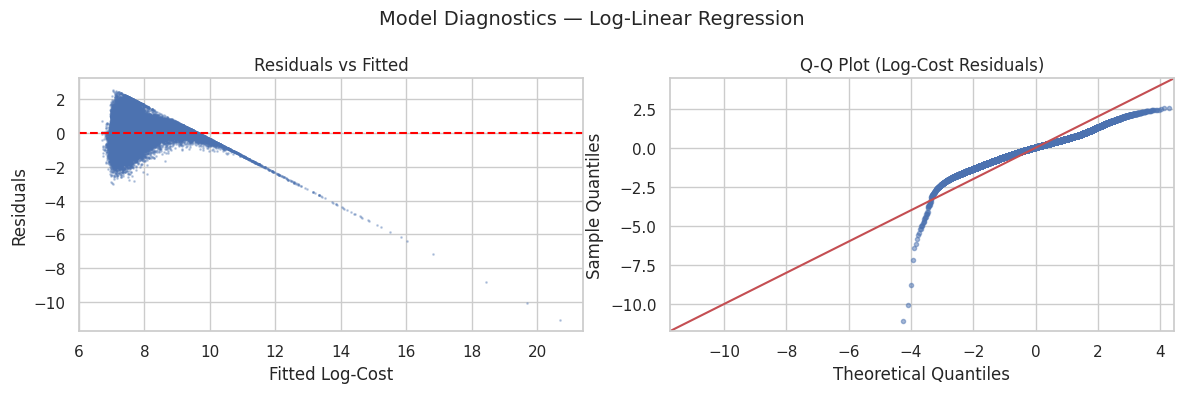


 Multicollinearity Check (VIF < 5 = acceptable):
      Variable    VIF
0        const  58.03
12  risk_score  12.13


In [24]:
# ==================================================
# STEP 4: MODEL DIAGNOSTICS & CRITICAL REFLECTION (LO4)
# ==================================================

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- 4.1 Residual Diagnostics ---
resid = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(12, 4))

# Residuals vs Fitted
plt.subplot(1, 2, 1)
plt.scatter(fitted, resid, alpha=0.3, s=1)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Log-Cost'); plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')

# Q-Q Plot
plt.subplot(1, 2, 2)
sm.qqplot(resid, line='45', ax=plt.gca(), marker='.', alpha=0.5)
plt.title('Q-Q Plot (Log-Cost Residuals)')

plt.suptitle('Model Diagnostics — Log-Linear Regression', fontsize=14)
plt.tight_layout()
plt.savefig('4_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 4.2 Multicollinearity Check (VIF) ---
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
print("\n Multicollinearity Check (VIF < 5 = acceptable):")
print(vif_data[vif_data['VIF'] > 5][['Variable', 'VIF']].round(2))